# DeepLab Demo

This demo will demostrate the steps to run deeplab semantic segmentation model on sample input images.

In [1]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import measure, draw
import json, codecs
import cv2
import pandas as pd
import tensorflow as tf

import base64

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.getcwd()

'/home/jovyan/AT073_10_Orig_Style/Libs/Tensorflow/models/deeplab'

In [3]:
os.chdir('/home/jovyan/AT073_10_Orig_Style/Libs/Tensorflow/models/data')

In [4]:
#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, modelPath, isTarFile=False):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    if isTarFile:
    # Extract frozen graph from tar archive.
      tar_file = tarfile.open(modelPath)
      for tar_info in tar_file.getmembers():
        if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
          file_handle = tar_file.extractfile(tar_info)
          graph_def = tf.GraphDef.FromString(file_handle.read())
          break

      tar_file.close()
    else:
      with open(modelPath, 'rb') as file_handle:
        graph_def = tf.GraphDef.FromString(file_handle.read())


    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [5]:
#@title Select and download models {display-mode: "form"}
isTarFile = True

modelPath = None
if isTarFile:
    MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
    _MODEL_URLS = {
        'mobilenetv2_coco_voctrainaug':
            'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
        'mobilenetv2_coco_voctrainval':
            'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
        'xception_coco_voctrainaug':
            'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
        'xception_coco_voctrainval':
            'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    }
    _TARBALL_NAME = 'deeplab_model.tar.gz'

    model_dir = tempfile.mkdtemp()
    tf.gfile.MakeDirs(model_dir)

    download_path = os.path.join(model_dir, _TARBALL_NAME)
    print('downloading model, this might take a while...')
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
    print('download completed! loading DeepLab model...')

    modelPath = download_path
else:
    modelPath = 'frozen_inference_graph.pb'
    
MODEL = DeepLabModel(modelPath, isTarFile)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that we are using single scale inference in the demo for fast computation,
so the results may slightly differ from the visualizations in
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md),
which uses multi-scale and left-right flipped inputs.

running deeplab on image 45589055_1623499911083924_310066260001914116_n.jpg...
(513, 410) int64
1080
1350
3
<class 'list'> 3 (2639, 2)


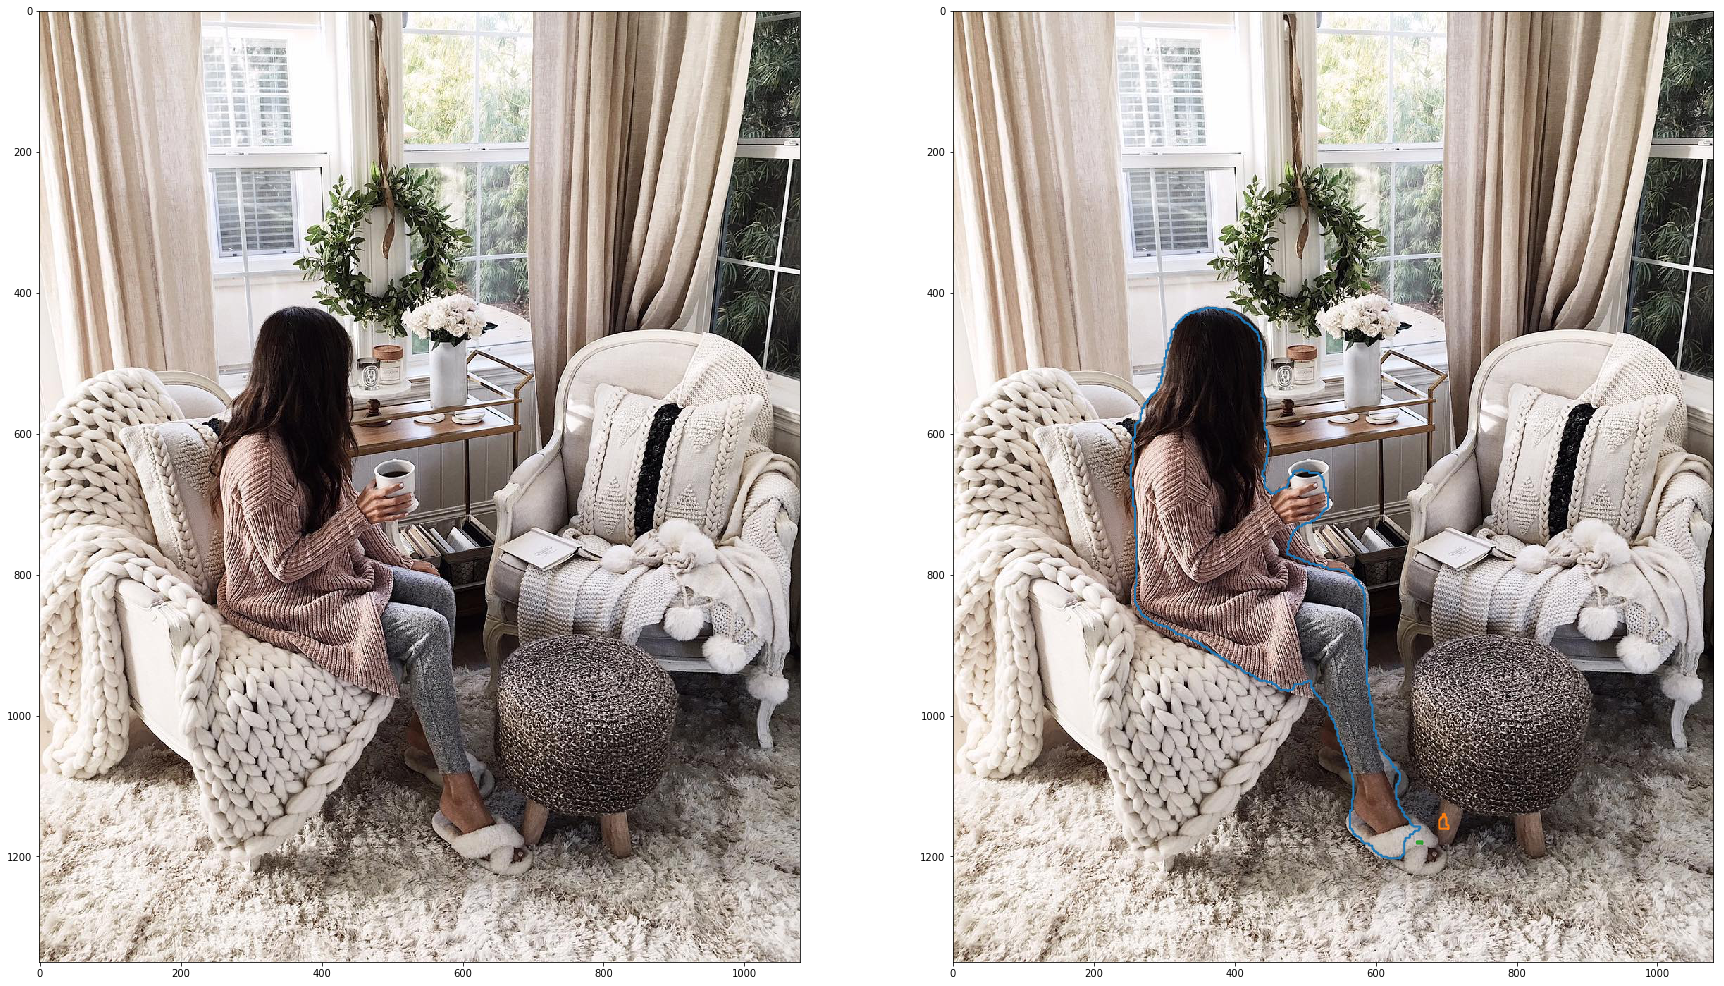

In [28]:
#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image3'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    # f = urllib.request.urlopen(url)
    # jpeg_str = f.read()
    # original_im = Image.open(BytesIO(jpeg_str))
    original_im = Image.open(url)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)
  print(seg_map.shape, seg_map.dtype)

  # vis_segmentation(resized_im, seg_map)


  # Find contours by using skimage API
  seg_map = cv2.resize(seg_map, original_im.size, interpolation=cv2.INTER_NEAREST)
  print(original_im.size[0])
  print(original_im.size[1])
  contours = measure.find_contours((seg_map == 15).astype(np.uint8) * 2, 1)
  if len(contours) > 0:
      print(len(contours))  
      print(type(contours), len(contours), contours[0].shape)


  fp = open( img+".json", "a")
  fp.write("{\n  \"version\": \"3.6.11\",\n  \"flags\": {},\n  \"shapes\": [\n")
  
  for i in range(len(contours)):
        fp = open( img+".json", "a")
        fp.write("   {\n      \"label\": \"person\",\n      \"line_color\": null,\n      \"fill_color\": null,\n      \"points\": ")
        fp.close()
        json.dump(contours[i][:, [1, 0]][0::50].tolist(),
            codecs.open( img+".json", 'a', encoding='utf-8'),
            separators=(',', ':'),
            indent=4)
        fp = open( img+".json", "a")
        fp.write(",\n      \"shape_type\": \"polygon\"\n    }")
        if i != (len(contours)-1):
            fp = open( img+".json", "a")
            fp.write(",")
        fp.close()
  fp = open( img+".json", "a") 
  fp.write("\n  ],\n  \"lineColor\": [\n    0,\n    255,\n    0,\n    288\n  ],\n  \"fillColor\": [\n    255,\n    0,\n    0,\n    128\n  ],\n  \"imagePath\": \"")
  fp.write(url)
  fp.write("\",\n  \"imageData\": \"")
  with open(url, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
  fp.write(str(encoded_string, encoding = "utf-8"))
  fp.write("\",\n  \"imageHeight\": %i, \n  \"imageWidth\": %i\n}" %(original_im.size[1], original_im.size[0]))
  fp.close()
   
#   fp = open("yun.json", "a")
#   fp.write(",\n      \"shape_type\": \"polygon\"\n    }\n  ],\n  \"lineColor\": [\n    0,\n    255,\n    0,\n    288\n  ],\n  \"fillColor\": [\n    255,\n    0,\n    0,\n    128\n  ],\n  \"imagePath\": \"")
#   fp.write(url)
#   fp.write("\",\n  \"imageData\": \"")
#   with open(url, "rb") as image_file:
#         encoded_string = base64.b64encode(image_file.read())
#   fp.write(str(encoded_string, encoding = "utf-8"))
#   fp.write("\",\n  \"imageHeight\": %i, \n  \"imageWidth\": %i\n}" %(original_im.size[1], original_im.size[0]))
#   fp.close()

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 20))
  ax0.imshow(original_im)
  ax1.imshow(original_im)

  for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)

#image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE

mydata = pd.DataFrame({'name':os.listdir('../data')})
mydata['path'] = '/home/jovyan/AT073_10_Orig_Style/Libs/Tensorflow/models/data/'+ mydata['name']
mydata['file'], mydata['doc_type'] = mydata['name'].str.split('.', 1).str
train_data = mydata[mydata['doc_type'].str.lower().eq('jpg')]

for img in train_data['file']:
    run_visualization(img + '.jpg')  #change image


In [19]:
mydata = pd.DataFrame({'name':os.listdir('../data')})
mydata['path'] = '/home/jovyan/AT073_10_Orig_Style/Libs/Tensorflow/models/data/'+ mydata['name']
mydata['file'], mydata['doc_type'] = mydata['name'].str.split('.', 1).str
train_data = mydata[mydata['doc_type'].str.lower().eq('jpg')]
train_data

,name,path,file,doc_type
0,44860747_258087788194176_4938956175369487601_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,44860747_258087788194176_4938956175369487601_n,jpg
1,45589055_1623499911083924_310066260001914116_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,45589055_1623499911083924_310066260001914116_n,jpg
2,38494665_1083934815087234_2447390382372159488_...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,38494665_1083934815087234_2447390382372159488_n,jpg
3,45472072_199866830956030_4973425409116655398_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,45472072_199866830956030_4973425409116655398_n,jpg
4,38236160_272696183527540_1642077593396051968_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,38236160_272696183527540_1642077593396051968_n,jpg
5,45376056_761481307577874_2605574848393030213_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,45376056_761481307577874_2605574848393030213_n,jpg
6,47584299_227719051485631_6690457527478748758_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,47584299_227719051485631_6690457527478748758_n,jpg
9,38188202_519461368488812_6404916138173530112_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,38188202_519461368488812_6404916138173530112_n,jpg
10,36804503_1076367029192809_4207940486805061632_...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,36804503_1076367029192809_4207940486805061632_n,jpg
11,41819994_256659118528797_5548039996389944768_n...,/home/jovyan/AT073_10_Orig_Style/Libs/Tensorfl...,41819994_256659118528797_5548039996389944768_n,jpg
